## Installation instructions

```bash
pip install music21
pip install geopy
pip install folium
pip install pandas
```

After installing music21, run the following

```python
import music21
music21.configure.run()
```

Follow the steps to configure music21

# Milestone 2
## 1. Gathering the data

**Remove for submission**

Here you can show that you understand your data and know how to use it. You can be brief in your answers. Section 1 may be supported with informative plots.
- [ ] Describe the dataset you selected and the information represented in it.
- [x] Based on your research question(s), why did you select this dataset?
- [ ] What aspects of the researched phenomena does the data (not) represent?
- [x] Where did you get your data from?
- [x] How did you get it?
- [x] What is the maximum available amount in theory (in the case of incomplete data acquisition)?
- [ ] If working on partial data, how representative is your sample for the full dataset?


As mentioned in the previous Milestone, answering our research questions related to the modal organization of Chinese Folk Songs (hereafter CFS) across China requires a dataset of CFS with the following properties:
1. The CFS must come from diverse regions of China
2. The origin of each song must be annotated
3. If possible, the tonic of each song should be annotated

By simply querying this information on a search engine, we found the [Essen Folksong Database](http://www.esac-data.org/). This database contains more than 20'000 scores of folksongs, of which approximately 2250 come from China. This dataset is particularly interesting as it contains the regional information required to answer our research questions. Indeed, not only are the Chinese scores classified into 4 distinct geographical regions (Han, Natmin, Shanxi, Xinhua), which shows diversity in their origins, but each piece also contains a more precise provenance (the province or city). Moreover, each song is annotated with its tonic, though it is unclear whether the annotation is manual or if it has been inferred by software. Therefore, as this dataset fulfills the three criteria above, it is well suited for our project. We can easily download all the relevant data of the Essen Collection from the [KernScore database](https://kern.humdrum.org/cgi-bin/browse?l=essen/asia/china) as a ZIP file. 

It is crucial to note that our dataset can never be exhaustive. Indeed, as we also explained in M1, CFS were an oral tradition and most of the transcriptions were made after the founding of New China in 1949. It is therefore very likely that many songs were forgotten throughout history. However, with almost 2250 CFS, we are confident that grouping them by region will allow us to get a general picture of the folk songs in each area.

## 2. Data format

**Remove for submission**

This section and the following are the main reason why this milestone is to be delivered in a Jupyter notebook: Give insightful examples for each one of the following questions by loading and transforming data samples.
- [x] What format(s) does the raw data come in?
- [x] How is the information that the dataset represents encoded in this format?
- [x] Load your dataset and show examples of how you access the information that you are interested in.
- [x] Give an overview of your dataset by plotting some basic statistics of the relevant features and/or metadata.


### 2.1 Kern Format
Originally, the Essen Folksong Database is in a particular format that is inspired by the *Jianpu* notation. While it may have been interesting to work with this format to analyze CFS, for simplicity reasons, we will use a translation of this database in *\*\*kern* format. As a summary, the information in *\*\*kern* files is represented as follows:
pitches are represented by letters and durations by numbers.

* Pitch
  * a-g are the absolute pitches above middle C
  * A-G are the absolute pitches below middle C
  * You can double any letter to represent higher or lower pitches
* Duration
  * 1 represents a whole note
  * 2 represents a half note
  * 4 represents a quarter note
  * etc...
* Accidentals
  * \# represents the sharp
  * \- represents the flat

On top of musical data, the *\*\*kern* files can also contain metadata in the format of comments or references. These are followed by a code that denotes what it is about. For instance, the title of the piece is typically indicated in a comment with the code `OTL`.


As a concrete example, here is the *\*\*kern* representation of the following score titled *My Kern Example*:

![lol](example_score.png)
```
!!!OTL: My Kern Example
**kern
{
1B
4g-
8ff
}
```

*\*\*kern* files also allow more complex music representation (e.g. glissando), which we will however mostly not need in this project. [The Humdrum website](https://www.humdrum.org/rep/kern/) provides a complete reference of the music notation in this format.


### 2.2 Examples on a single score
Luckily, we do not need to write a parser to work with \*\*kern files, as this can be done using the *music21* module, which can be easily installed via *pip*.

In [34]:
# Imports 

from music21 import *
import glob
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter
from geopy.geocoders import Nominatim
import re
import folium
import networkx as nx
plt.rcParams["figure.figsize"] = (20,5)


#NOTE TO RAVI AND ZIJUN : This is the MuseCore path on my Computer, you will need to download MuseScore and to specify the path yourself
#Maybe for the final report we indeed only let the .configure thing (although it did not work on my computer)
environment.set('musescoreDirectPNGPath', 'C:\Program Files\MuseScore 3\\bin\\MuseScore3.exe')

As an example, let's load one song from the regional category *Han* and display it.

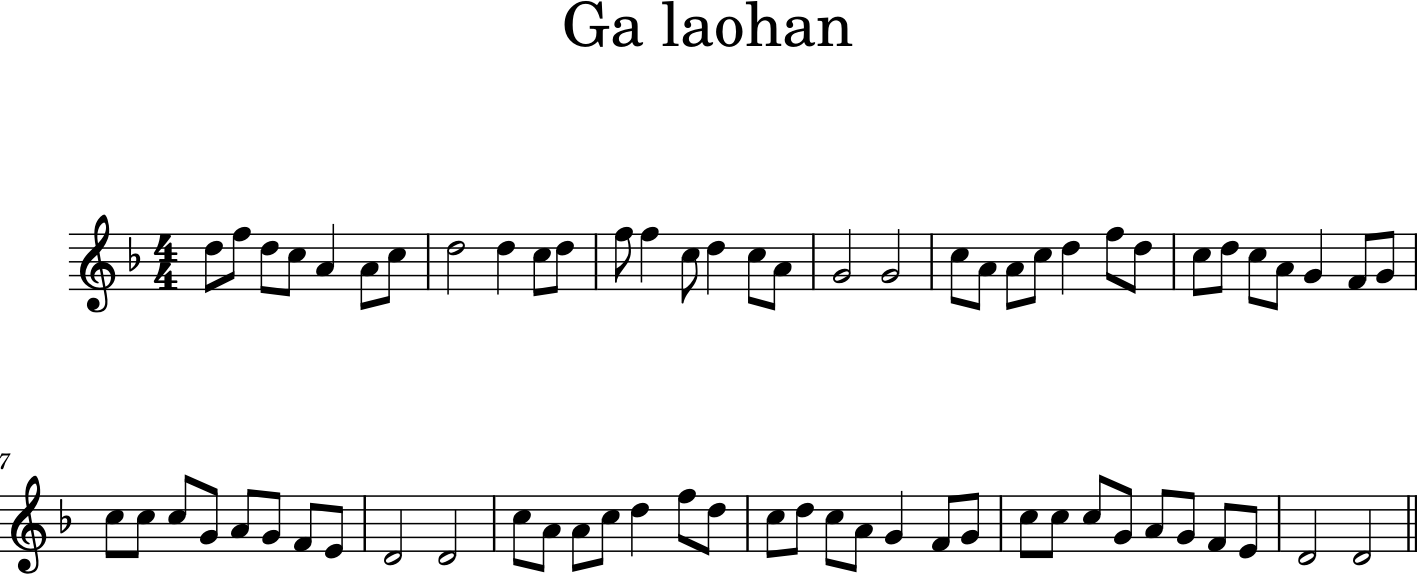

In [2]:
score = converter.parse("./data/han/han0111.krn")
score.show()

First, we are interested in the origin of the song. Apart from the regional category (*Han*), the more precise origin of the song is contained in a `GlobalReference` with the code `ARE`. One way to access it is to iterate over all the elements and only print it if it is an element of that type with the correct code.

In [3]:
for element in score:
    if type(element) is humdrum.spineParser.GlobalReference and element.code == "ARE":
        print(element.value)

Asia, China,ÿQinghai, Osten


Second, as our analysis will rely on scale degrees, we will need to access the pitches and their durations as well as the tonic. The following snippet allows us to access all the notes of the first measure and the tonic of the piece.

In [4]:
for part in score.parts:
    for element in part.measure(0):
        if type(element) is key.Key:
            print(f"The tonic is : {element.tonic}")
        if type(element) is note.Note:
            print(element.pitch, element.duration.quarterLength)

The tonic is : F
D5 0.5
F5 0.5
D5 0.5
C5 0.5
A4 1.0
A4 0.5
C5 0.5


It takes only a short visual analysis to notice that it is **extremely** unlikely that F is the tonic of this piece. Indeed, it looks like the tonic is D. Therefore we cannot rely on this annotation and we will have to infer the tonic ourselves (cf. Part 3).

For the sake of this single example, let's assume that its tonic is indeed D. With this information, we can now infer what pentatonic scale is used in this piece. For this purpose, we first need to transpose the piece to C relatively to its tonic (in this case a transposition of -2 since there are 2 semitones between C and D). We can easily use *music21*'s `transpose` method to do it

In [5]:
transposed_score = score.transpose(-2)

We can now use *music21*'s `plot` method to get a general plot of the pitch classes used in this transposed piece.

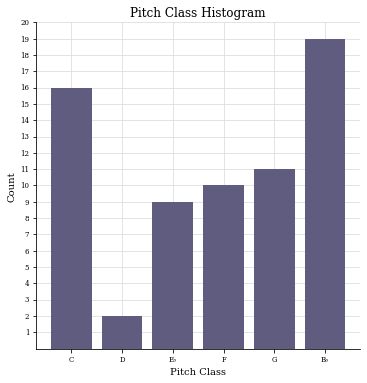

In [6]:
transposed_score.plot('histogram', 'pitchclass')

A quick visual inspection of this plot shows us that the most used pitches after transposing are C E<sub>b</sub> F G B<sub>b</sub> which corresponds to the *minor* pentatonic scale

### 2.3 Statistics on the whole dataset

In [7]:
# A list to store the regions from which which the music pieces are obtained.

regions = ["han", "natmin", "shanxi", "xinhua"]

First, we will need to read the whole dataset and store it as a pandas data frame to use for future purposes.

#### Creation of dataframe

In [8]:
def load_files(path):
    """
    The function accepts a path and loads the .krn files in the path into a list.
    The pieces that are successfully parsed by the music21 parsers are stored in the scores list.
    In case the parser fails to load any file, they are stored in failed_scores.
    The count of total scores and failed scores are stores in total and failed counters.
    """
    
    pieces = {"scores": [], "failed_scores": [], "total": 0, "failed": 0}
    for file in tqdm(glob.glob(path+"/*.krn")):
        pieces["total"] += 1
        try:
            pieces["scores"].append(converter.parse(file))
        except:
            pieces["failed"] += 1 
            pieces["failed_scores"].append(converter.parse(file))
            
    return pieces

using the `load_scores` function, we store the music of each region into a dictionary with the name of the region as key and the output of the `load_scores` as value

In [9]:
music_data = {}

for gloc in regions:
    music_data[gloc] = load_files("./data/"+gloc)

100%|██████████| 10/10 [00:00<00:00, 125.78it/s]


##### Computing the tonic of a score

**TBD: Describes the procees we use to infer the tonic.**

In [ ]:
def get_tonic(score):
    """
    This function accepts a score and returns its tonic, pitch classes, and 5 most frequent pitch, classes
    using the method described above.
    """
    try:
        note_scores = dict()
        for part in score.parts:
            for measure in part:
                if type(measure) is not stream.Measure:
                    continue
                for note_ in measure:
                    if type(note_) is not note.Note:
                        continue
                    if note_.name in note_scores.keys():
                        note_scores[note_.name] += note_.duration.quarterLength * note_.beatStrength
                    else:
                        note_scores[note_.name] = note_.duration.quarterLength * note_.beatStrength
        tonic = max(note_scores, key=note_scores.get)
    except:
        tonic = None
    
    pitchclasses = list(note_scores.keys())
    top5 = sorted(note_scores, key=note_scores.get, reverse=True)[:5]
    return tonic, pitchclasses, top5

##### Logic for the creation of one row in the data frame.

All the music scores are store in a dictionary `music_data` with a key as the geographical region. 
- For each geographic region
    - Get the music pieces of the region.
    - For each piece
        1. we get the title of the piece
        2. we get the number notes in the piece
        3. we get the location to which the piece belongs (finer than region).
        4. we use the `get_tonic` function to obtain the tonic, pitch classes, and the 5 most frequent pitch classes present in the piece.
        5. We transpose the piece to C and obtain the new pitch classes using the `get_tonic` function.
            - We calculate the number of semitones between the tonic of the piece and 'C' and transpose the piece by that value
        6. We then get the pitches present in the transposed piece
        7. All this information is appended to a list

In [ ]:
# create a empty list to store information about each piece.
CFS_list = []

for gloc in tqdm(music_data):
    pitchclass_trasition[gloc] = {}
    
    for score in music_data[gloc]["scores"]:
        
        title = score.metadata.title
        
        for element in score:
            if type(element) is humdrum.spineParser.GlobalReference and element.code == "ARE":
                location = element.value
                
        tonic, pitchclasses, _ = get_tonic(score)
        num_pitchclass = len(pitchclasses)
        pitches = [str(pitch) for pitch in score.pitches]
        num_notes = len(pitches)
        
        
        # transposing
        i = interval.Interval(pitch.Pitch(tonic), pitch.Pitch("C")).semitones
        scoreNew = score.transpose(i)
        
        tonic_transposed, pitchclasses_transposed, top5 = get_tonic(scoreNew)
        pitches_transposed = [str(pitch) for pitch in scoreNew.pitches]
        
        CFS_list.append([gloc, title, location, tonic, pitches, num_notes, pitchclasses, num_pitchclass, tonic_transposed, pitches_transposed, pitchclasses_transposed, top5])

Create the data frame from the list by providing the appropriate headers

In [ ]:
CFS_full = pd.DataFrame(CFS_list, columns=["region", "title", "location", "tonic", "pitches", "num_notes", "pitchclasses", "num_pitchclasses","tonic_transposed", "pitches_transposed", "pitchclasses_transposed", "top5_after_transpose"])
CFS_full

Saving the data frame to a file

In [ ]:
CFS_full.to_csv("./data/dataframes/cfs_full.csv", index=False)

##### Reading the data from csv file

We have created a CSV file with a row for each piece containing the following columns: region, title, location, tonic, pitches, num_notes, pitchclasses, num_pitchclasses, tonic_transposed, pitches_transposed, pitchclasses_transposed, top5_after_transpose. As the process of creation takes time, we load it from the memory next time.

_Note_: We store the pitches, pitch classes (after and before transposition) as lists. Hence when reading the CSV, we use converters to convert them into lists.

In [58]:
CFS_full = pd.read_csv("./data/dataframes/cfs_full.csv", converters={'pitches': eval,'pitchclasses': eval,'pitches_transposed': eval,'pitchclasses_transposed': eval,'top5_after_transpose': eval})
CFS_full.head()

,region,title,location,tonic,pitches,num_notes,pitchclasses,num_pitchclasses,tonic_transposed,pitches_transposed,pitchclasses_transposed,top5_after_transpose
0,han,Renmin gongshe shizai hao,"Asia, China, Shanxi, Zizhou",D,"[D5, A4, C5, D5, D5, A4, C5, D5, G5, C5, A4, G...",64,"[D, A, C, G, E, F#]",6,C,"[C5, G4, B-4, C5, C5, G4, B-4, C5, F5, B-4, G4...","[C, G, B-, F, D, E]","[C, B-, F, G, D]"
1,han,Zanmen de ling xiu Mao Zedong,"Asia, China, Shanxi Nordwesten",C,"[C5, C5, F5, C5, B-4, G4, C5, E-4, F4, G4, C5,...",57,"[C, F, B-, G, E-, D, A]",7,C,"[C5, C5, F5, C5, B-4, G4, C5, E-4, F4, G4, C5,...","[C, F, B-, G, E-, D, A]","[C, G, F, E-, D]"
2,han,Tian xin shun,"Asia, China, Shanxi Yanchang",D,"[D5, A4, D5, D5, A4, D5, A4, D5, G4, E4, D4, D...",24,"[D, A, G, E, B]",5,C,"[C5, G4, C5, C5, G4, C5, G4, C5, F4, D4, C4, C...","[C, G, F, D, A]","[C, G, F, D, A]"
3,han,Liu zhi dan,"Asia, China, Shanxi Shanbei",B-,"[E-5, C5, B-4, A-4, B-4, E-4, F4, E-5, C5, B-4...",41,"[E-, C, B-, A-, F]",5,C,"[F4, D4, C4, B-3, C4, F3, G3, F4, D4, C4, B-3,...","[F, D, C, B-, G]","[C, F, G, B-, D]"
4,han,Zanmen de hongjun shi li zhong,"Asia, China, Shanxi Shanbei",E,"[E5, E4, A4, G4, A4, B4, E5, D5, E5, B4, E5, E...",24,"[E, A, G, B, D]",5,C,"[C5, C4, F4, E-4, F4, G4, C5, B-4, C5, G4, C5,...","[C, F, E-, G, B-]","[C, G, F, B-, E-]"


Considering that the region division of the raw data is not standardized, we re-divided the regions of these folk songs into 8 regions according to provinces. (Please refer to map.jpg)

In [116]:
CFS_full['geo_division'] = ''
CFS_full.loc[CFS_full['location'].str.contains('Shanxi|Ningxia|Gansu|Qinghai'), ['geo_division']] = 'Northwest'
CFS_full.loc[CFS_full['location'].str.contains('Neimeng'), ['geo_division']] = 'Neimeng'
CFS_full.loc[CFS_full['location'].str.contains('Shandong|Hebei|Liaoning|Jilin|Heilongjiang'), ['geo_division']] = 'Northeast'
CFS_full.loc[CFS_full['location'].str.contains('Jiangsu|Anhui|Zhejiang'), ['geo_division']] = 'Jiangzhe'
CFS_full.loc[CFS_full['location'].str.contains('Hubei|Hunan|Henan|Jiangxi'), ['geo_division']] = 'Central'
CFS_full.loc[CFS_full['location'].str.contains('Fujian|Guangdong|Taiwan'), ['geo_division']] = 'Southeast'
CFS_full.loc[CFS_full['location'].str.contains('Sichuan|Chongqing|Yunnan|Guangxi|Hainan'), ['geo_division']] = 'Southwest'
CFS_full.loc[CFS_full['location'].str.contains('Xinjiang'), ['geo_division']] = 'Jiang' 
CFS_full.loc[CFS_full['geo_division'] == '', ['geo_division']] = 'Null' 
CFS_full.head()

,region,title,location,tonic,pitches,num_notes,pitchclasses,num_pitchclasses,tonic_transposed,pitches_transposed,pitchclasses_transposed,top5_after_transpose,province,true_location,geo_division
0,han,Renmin gongshe shizai hao,"Asia, China, Shanxi, Zizhou",D,"[D5, A4, C5, D5, D5, A4, C5, D5, G5, C5, A4, G...",64,"[D, A, C, G, E, F#]",6,C,"[C5, G4, B-4, C5, C5, G4, B-4, C5, F5, B-4, G4...","[C, G, B-, F, D, E]","[C, B-, F, G, D]",Shanxi,"(子洲县, 子洲县 (Zizhou), 陕西省, 中国, (37.6089977, 110....",Northwest
1,han,Zanmen de ling xiu Mao Zedong,"Asia, China, Shanxi Nordwesten",C,"[C5, C5, F5, C5, B-4, G4, C5, E-4, F4, G4, C5,...",57,"[C, F, B-, G, E-, D, A]",7,C,"[C5, C5, F5, C5, B-4, G4, C5, E-4, F4, G4, C5,...","[C, F, B-, G, E-, D, A]","[C, G, F, E-, D]",Shanxi,"(Tây Bắc, Việt Nam, (21.559862449999997, 103.6...",Northwest
2,han,Tian xin shun,"Asia, China, Shanxi Yanchang",D,"[D5, A4, D5, D5, A4, D5, A4, D5, G4, E4, D4, D...",24,"[D, A, G, E, B]",5,C,"[C5, G4, C5, C5, G4, C5, G4, C5, F4, D4, C4, C...","[C, G, F, D, A]","[C, G, F, D, A]",Shanxi,"(烟厂, 龙山县, 湖南省, 中国, (29.364122, 109.581649))",Northwest
3,han,Liu zhi dan,"Asia, China, Shanxi Shanbei",B-,"[E-5, C5, B-4, A-4, B-4, E-4, F4, E-5, C5, B-4...",41,"[E-, C, B-, A-, F]",5,C,"[F4, D4, C4, B-3, C4, F3, G3, F4, D4, C4, B-3,...","[F, D, C, B-, G]","[C, F, G, B-, D]",Shanxi,"(陕北, 中国, (37.47371335, 109.01464347366176))",Northwest
4,han,Zanmen de hongjun shi li zhong,"Asia, China, Shanxi Shanbei",E,"[E5, E4, A4, G4, A4, B4, E5, D5, E5, B4, E5, E...",24,"[E, A, G, B, D]",5,C,"[C5, C4, F4, E-4, F4, G4, C5, B-4, C5, G4, C5,...","[C, F, E-, G, B-]","[C, G, F, B-, E-]",Shanxi,"(陕北, 中国, (37.47371335, 109.01464347366176))",Northwest


##### Dataset Overview

First, we plot the distribution of the pieces over the regions.

Text(0.5, 1.0, 'Number of Chinese Folk Songs from each region')

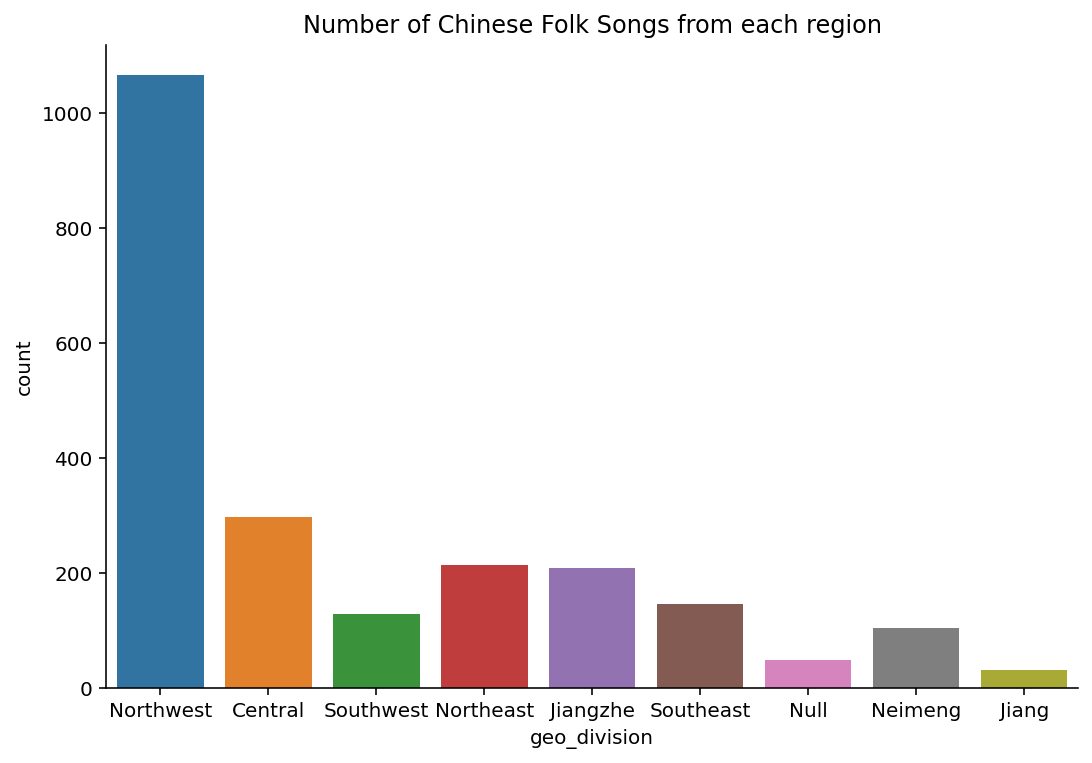

In [117]:
sns.catplot(x="geo_division", kind="count", data=CFS_full, aspect=1.5)
plt.title("Number of Chinese Folk Songs from each region")

We observe that the highest number of pieces are from Han (\~1200), followed by Shanxi (\~800). The least number of pieces are from Natmin (\~200) and Xinhua (=10). Clearly, the number of songs from the Xinhua region is underrepresented in the dataset when compared with other regions.

Next, we look at the length of the pieces through the number of notes present in the piece.

Text(0.5, 1.0, 'Distribution of length of Chinese Folk Songs from each region')

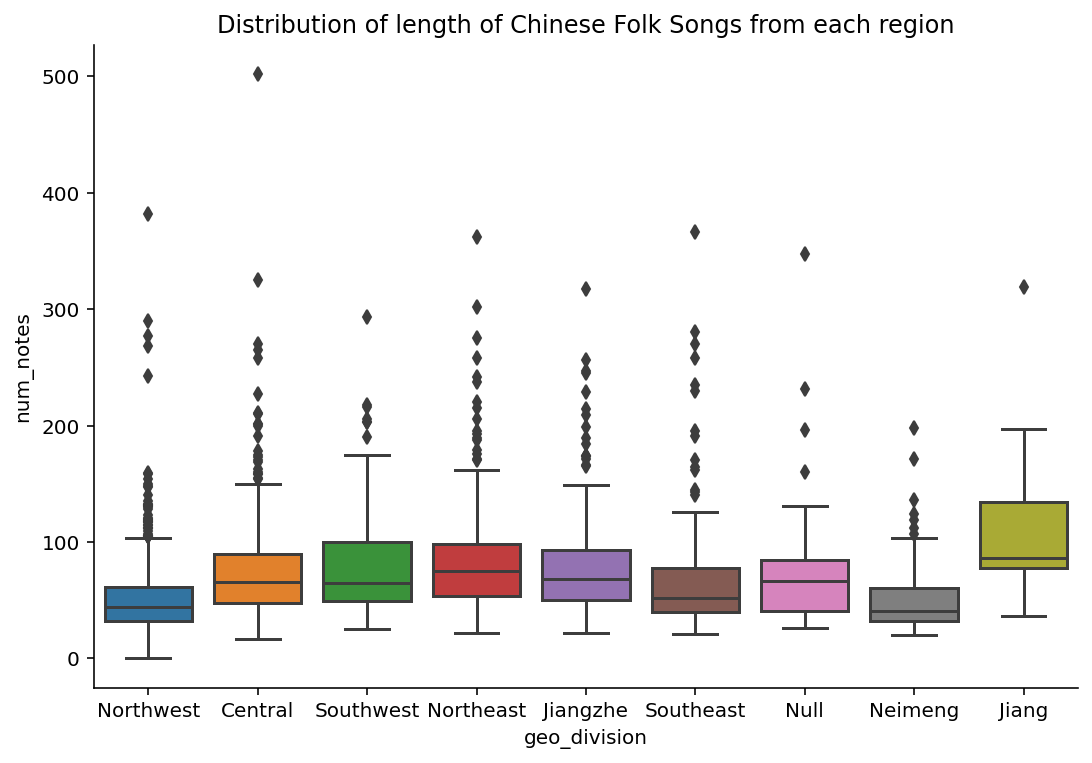

In [119]:
sns.catplot(x="geo_division", y="num_notes", data=CFS_full, kind="box", aspect=1.5)
plt.title("Distribution of length of Chinese Folk Songs from each region")

On average each piece has 70 to 75 notes in the Han, Shanxi, and Natmin regions, whereas the mean number of notes in Xinhua is around 120

Similar to the pitches, next we look at the number of pitch classes present in pieces across regions

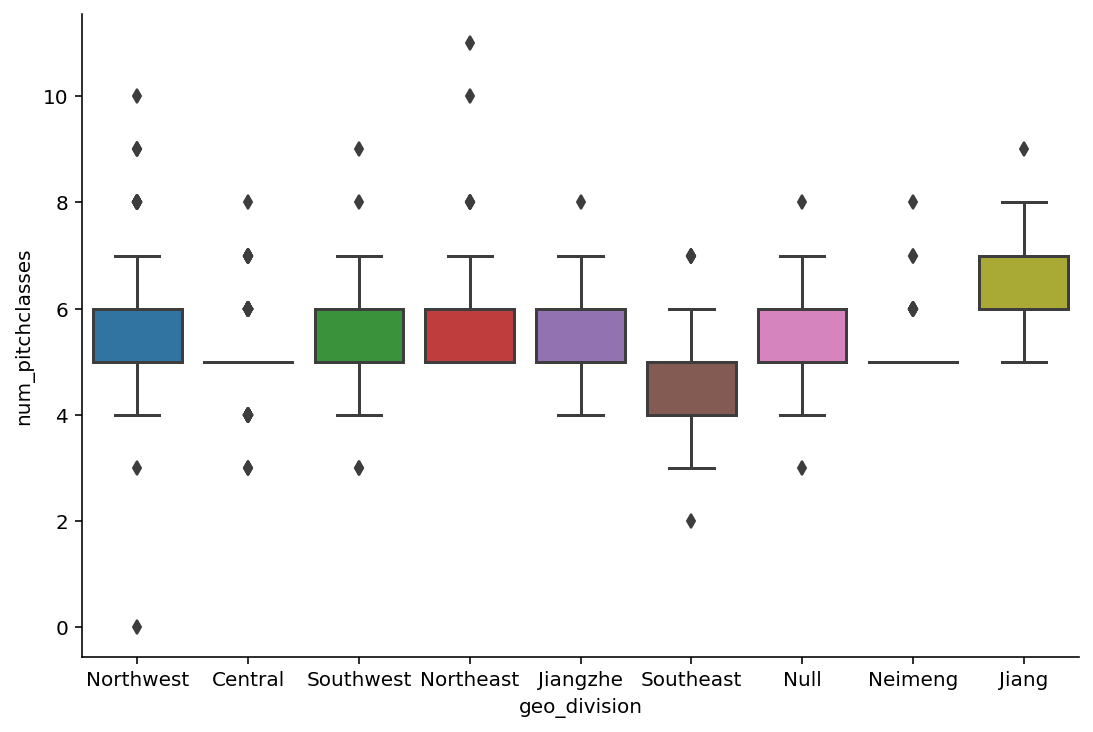

In [120]:
sns.catplot(x="geo_division", y="num_pitchclasses", data=CFS_full, kind="box", aspect=1.5)

On average each piece has 5 pitch classes (The pieces are from a pentatonic scale).

Next, we look at the distribution of songs across Geographical Locations

In [62]:
cache = dict()
def name_to_location(name):
    geolocator = Nominatim(user_agent="DH-401 CFS")
    names = name.strip(" ").replace(", ", ",").replace(" ", ",").split(",")
    for i in range(len(names)):
        if names[len(names)-1-i] in cache.keys():
            return cache[names[len(names)-1-i]]
        location = geolocator.geocode(names[len(names)-1-i])
        if location is not None:
            cache[names[len(names)-1-i]] = location
            return location
    return None

In [63]:
#Takes an eternity to run
CFS_full["true_location"] = CFS_full.location.apply(name_to_location)

In [105]:
map_ = folium.Map()
locations = list()
for _, row in CFS_full.iterrows():
    if row["true_location"] is None:
        continue
    if row["true_location"].latitude + row["true_location"].longitude in locations:
        continue
    if row["region"] == "han":
        color = "blue"
    elif row["region"] == "shanxi":
        color="red"
    elif row["region"] == "natmin":
        color="black"
    else:
        color = "green"
    folium.Marker([row["true_location"].latitude, row["true_location"].longitude], popup=row["location"], icon=folium.Icon(color=color)).add_to(map_)
    locations.append(row["true_location"].latitude + row["true_location"].longitude)

In [106]:
map_

# 3. Exploratory analysis

**Remove for submission**

Perform an exploratory analysis on your data. In this section of your report please address the following points:
- [ ] Which analyses or experiments did you perform as part of your exploratory analysis of the data and what are the results? Choose suitable visualizations to show your results.
- [ ] How do the results relate to your hypotheses?
- [ ] Did you find interesting or unexpected things? How do they influence the development of your project?
- [ ] What are problems that you encountered? How could you plan to deal with them?
- [ ] Discuss how the data enables you to answer your research question(s).
- [ ] Formulate educated guesses on your outcomes based on this data.
- [ ] Reflect on how, at the end of the analysis, you will be able to tell whether these outcomes have manifested or not and how confident you will possibly be about this assessment.


As part of the EDA, we first do the simple analysis of counting the occurrences of each pitch and pitch class. Later we transpose all the pieces to C and repeat the plotting.

### Pitch statistics

In this section, we try to plot the combined pitch statistics of all the pieces separated by regions. There is a pitch statistics plot and pitch-class before transposing all the pieces in C and after transposing.

First, we create empty dictionaries to store the pitches and pitches classes before and after transposition with region name as key and values as a list of pitches (pitch classes) of all pieces belonging to that region.

In [15]:
region_pitch_stat = {}
region_pitchclass_stat = {}
region_pitch_transposed_stat = {}
region_pitchclass_transposed_stat = {}

pitchclasses_defcount = {"A":0, "A#": 0, "A-": 0,
                 "B":0, "B#": 0, "B-": 0,
                 "C":0, "C#": 0, "C-":0,
                 "D":0, "D#": 0, "D-":0,
                 "E":0, "E#": 0, "E-":0,
                 "F":0, "F#": 0, "E-":0,
                 "G":0, "G#": 0, "G-":0} 

for gloc in regions: 
    region_df = CFS_full[CFS_full["region"]==gloc]
    region_pitch_stat[gloc] = sum(region_df["pitches"].tolist(), [])
    region_pitchclass_stat[gloc] = sum(region_df["pitchclasses"].tolist(), [])
    region_pitch_transposed_stat[gloc] = sum(region_df["pitches_transposed"].tolist(), [])
    region_pitchclass_transposed_stat[gloc] = sum(region_df["pitchclasses_transposed"].tolist(), [])

To plot the pitch statistics, we count the occurrence of each pitch and then normalize the count between 0 and 1. Then we plot a bar chart

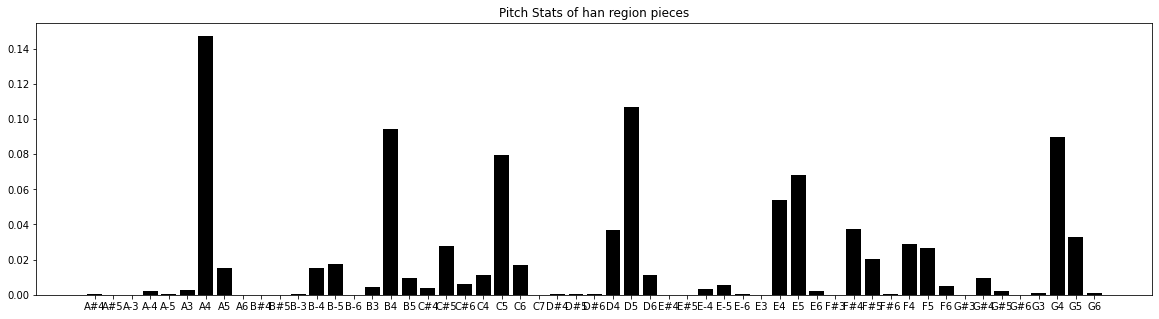

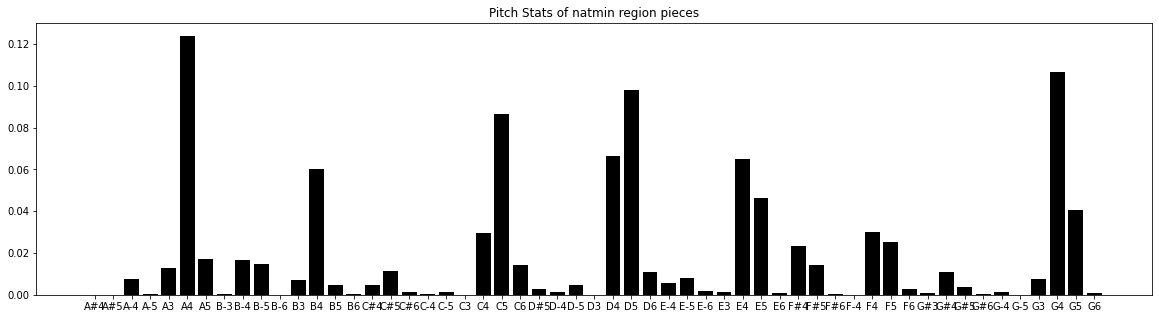

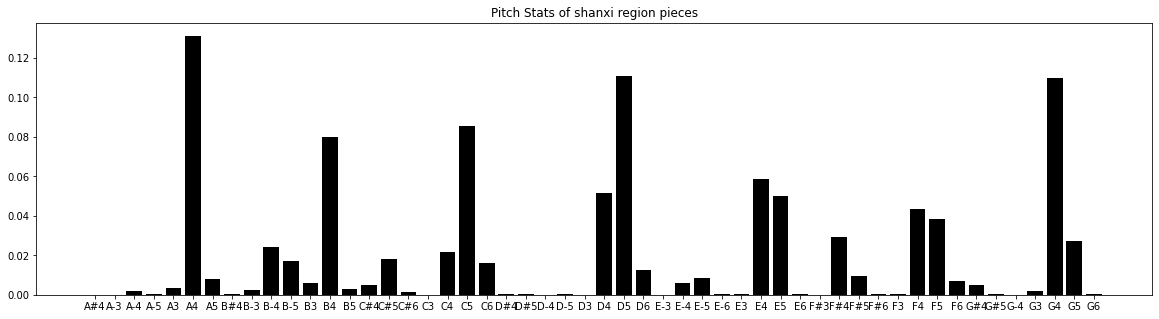

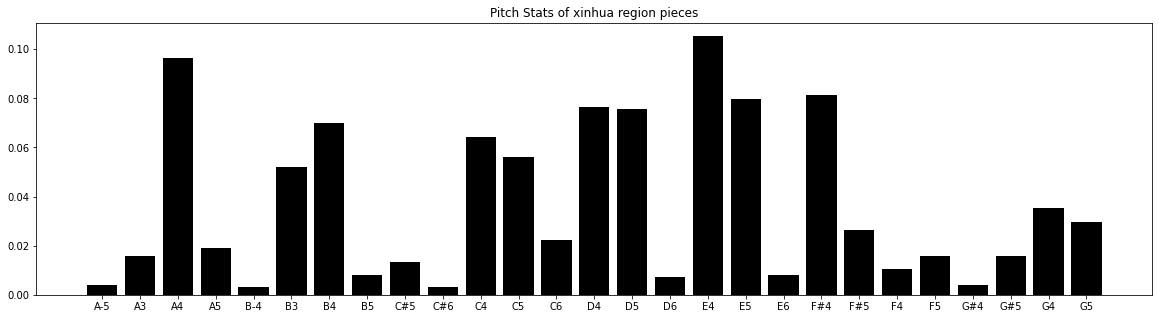

In [16]:
region_pitch_counts = {}
for gloc in region_pitch_stat:
    
    counter = Counter(region_pitch_stat[gloc])
    pitch_fractions = {i:counter[i] / len(region_pitch_stat[gloc]) for i in counter}
    region_pitch_counts[gloc] = sorted(pitch_fractions.items(), key=lambda pair: pair[0])
    
    x, y = zip(*region_pitch_counts[gloc])
    
    plt.bar(x, y, color='black')
    plt.title("Pitch Stats of {} region pieces".format(gloc))
    plt.show()

While plotting the pitch classes is similar to that of pitches, we additionally add 0 counts to those pitch classes that have not occurred in any piece belonging to the region and we sort the based on the fraction of occurrence instead of alphabetical order of the pitch classes.

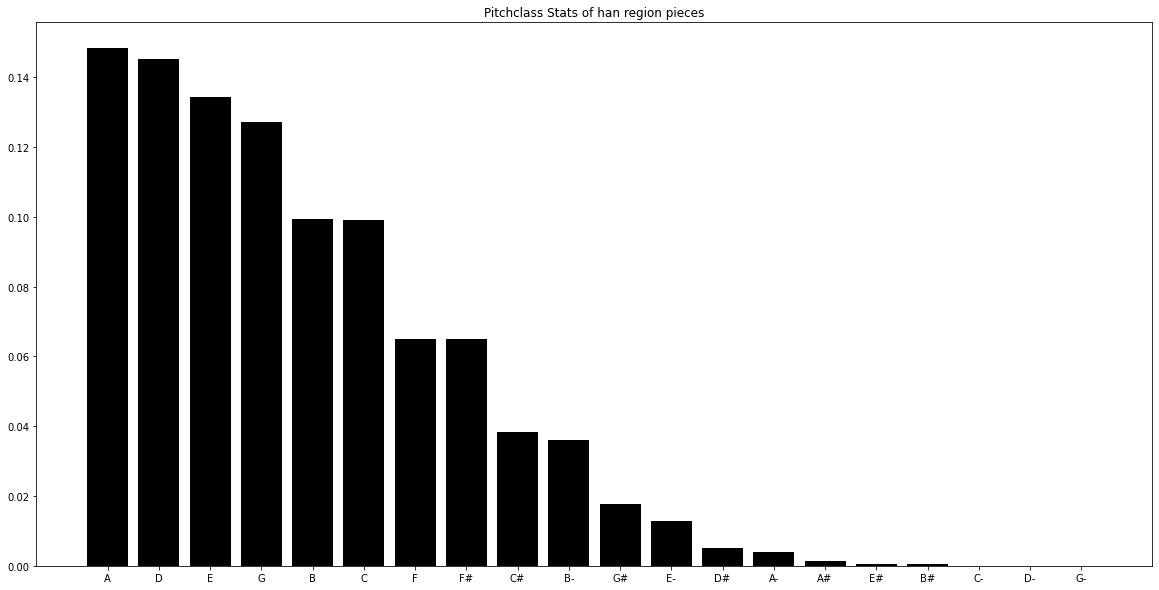

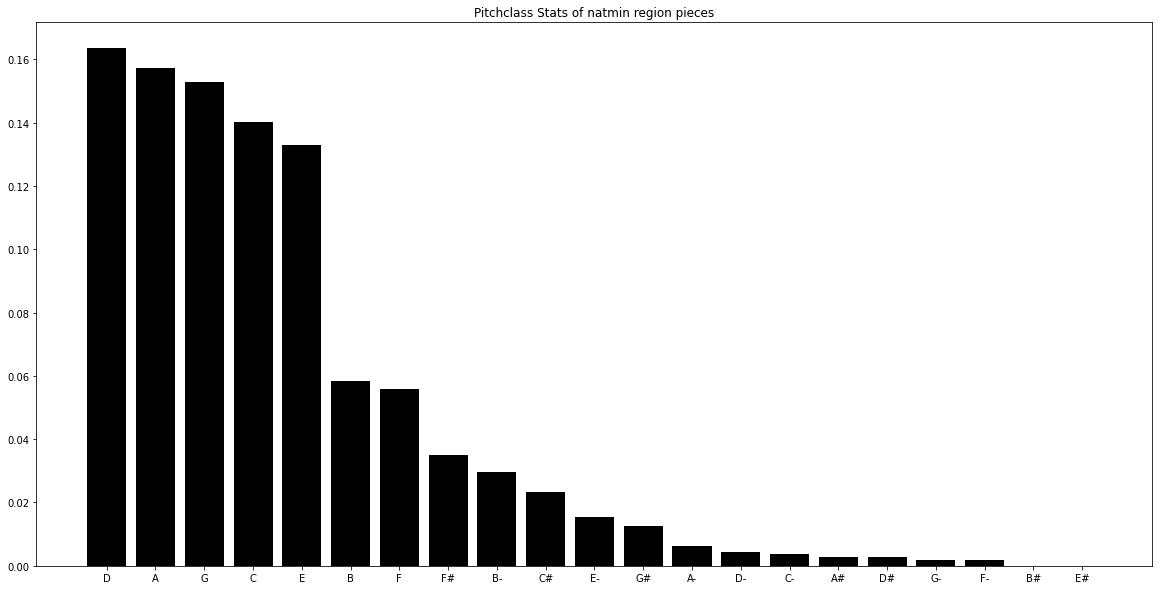

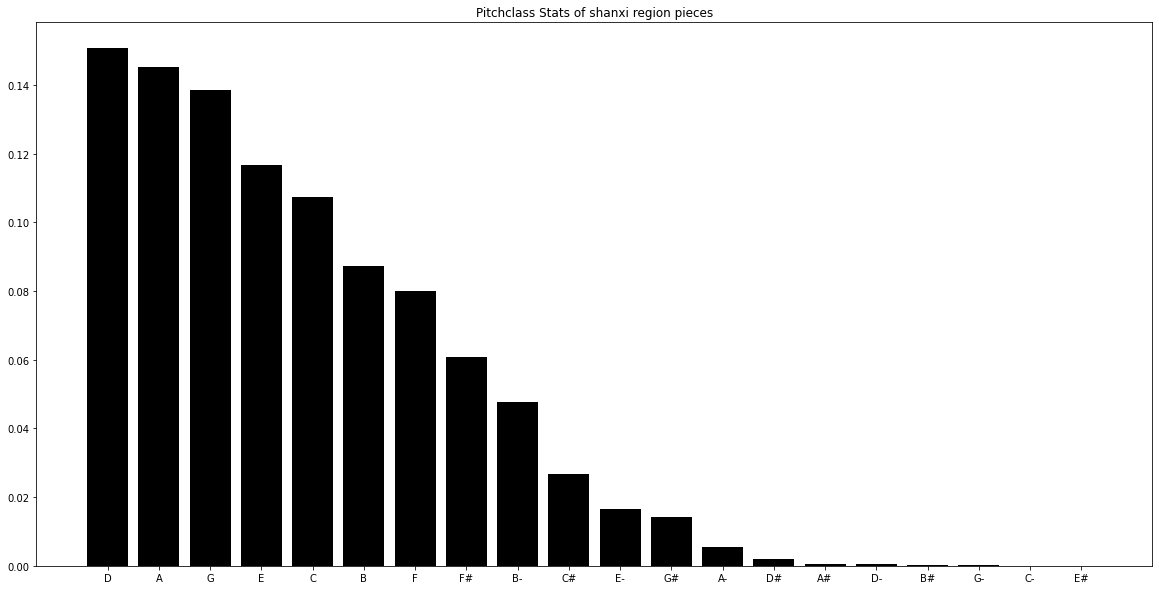

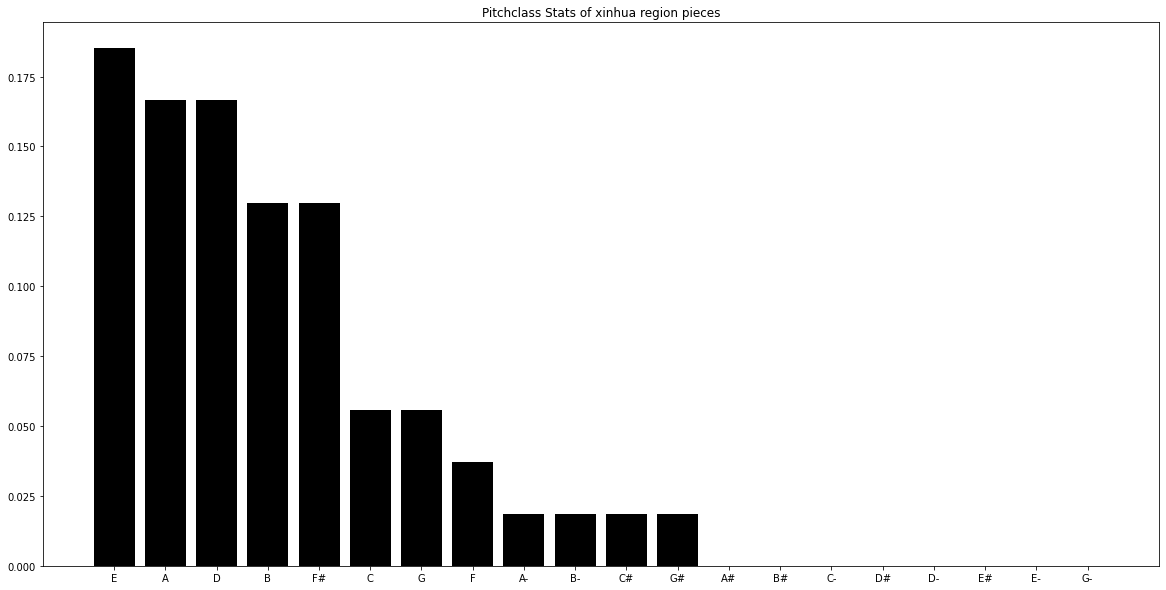

In [26]:
region_pitchclass_counts = {}
for gloc in region_pitchclass_stat:
    
    counter = Counter(region_pitchclass_stat[gloc])
    pitchclass_fractions = {i:counter[i] / len(region_pitchclass_stat[gloc]) for i in counter}
    pitchclass_fractions = {**pitchclasses_defcount, **pitchclass_fractions}
    region_pitchclass_counts[gloc] = sorted(pitchclass_fractions.items(), key=lambda pair: -pair[1])
    x, y = zip(*region_pitchclass_counts[gloc])
    plt.bar(x, y, color='black')
    plt.title("Pitchclass Stats of {} region pieces".format(gloc))
    plt.show()

The plotting of pitch and pitch classes after transposing is similar to the previous ones.

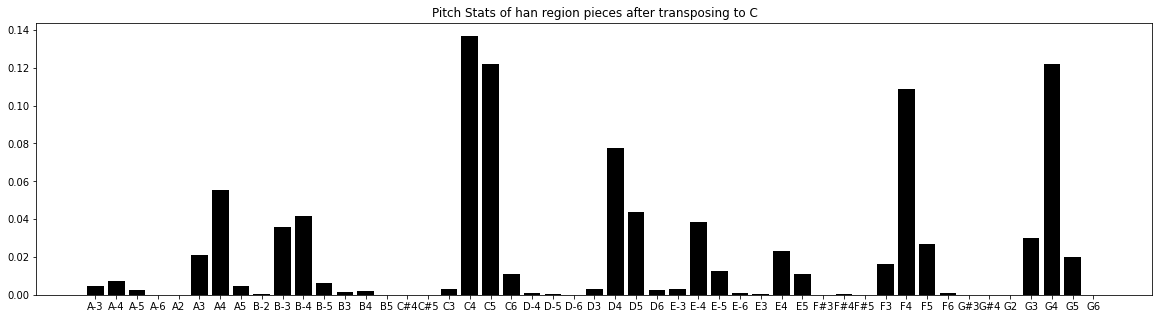

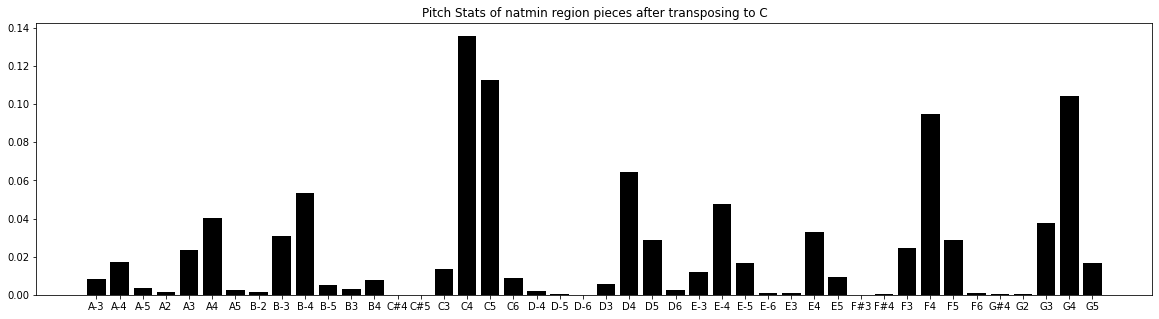

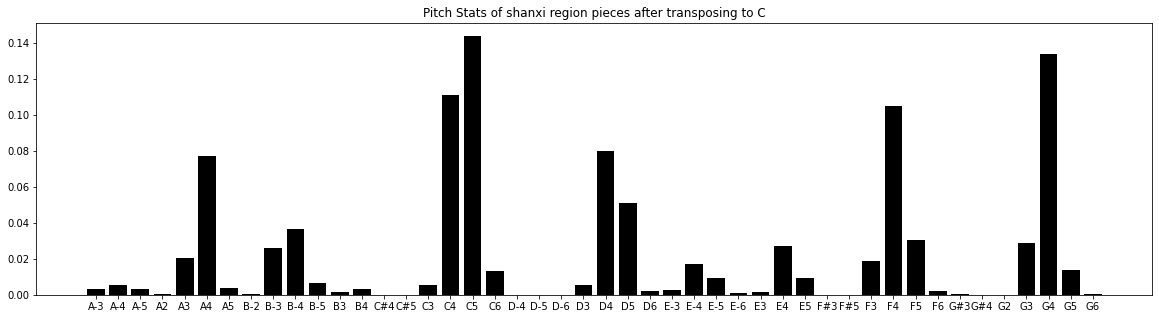

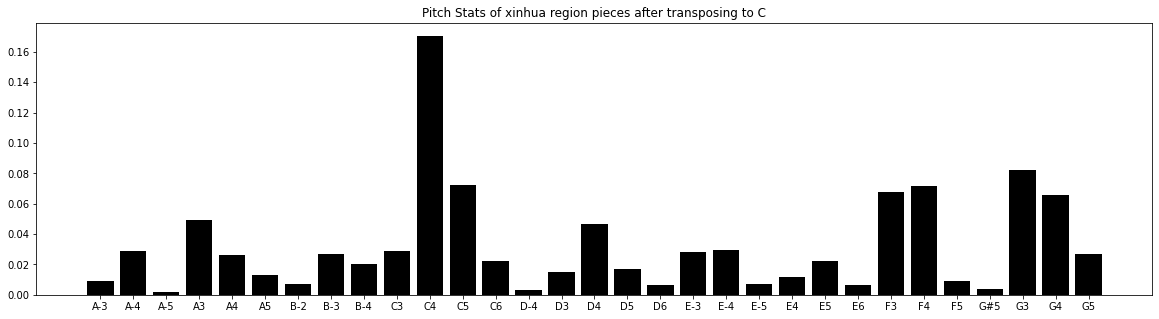

In [18]:
region_pitch_transposed_counts = {}
for gloc in region_pitch_transposed_stat:
    
    counter = Counter(region_pitch_transposed_stat[gloc])
    pitch_transposed_fractions = {i:counter[i] / len(region_pitch_transposed_stat[gloc]) for i in counter}
    
    region_pitch_transposed_counts[gloc] = sorted(pitch_transposed_fractions.items(), key=lambda pair: pair[0])
    x, y = zip(*region_pitch_transposed_counts[gloc])
    plt.bar(x, y, color='black')
    plt.title("Pitch Stats of {} region pieces after transposing to C".format(gloc))
    plt.show()

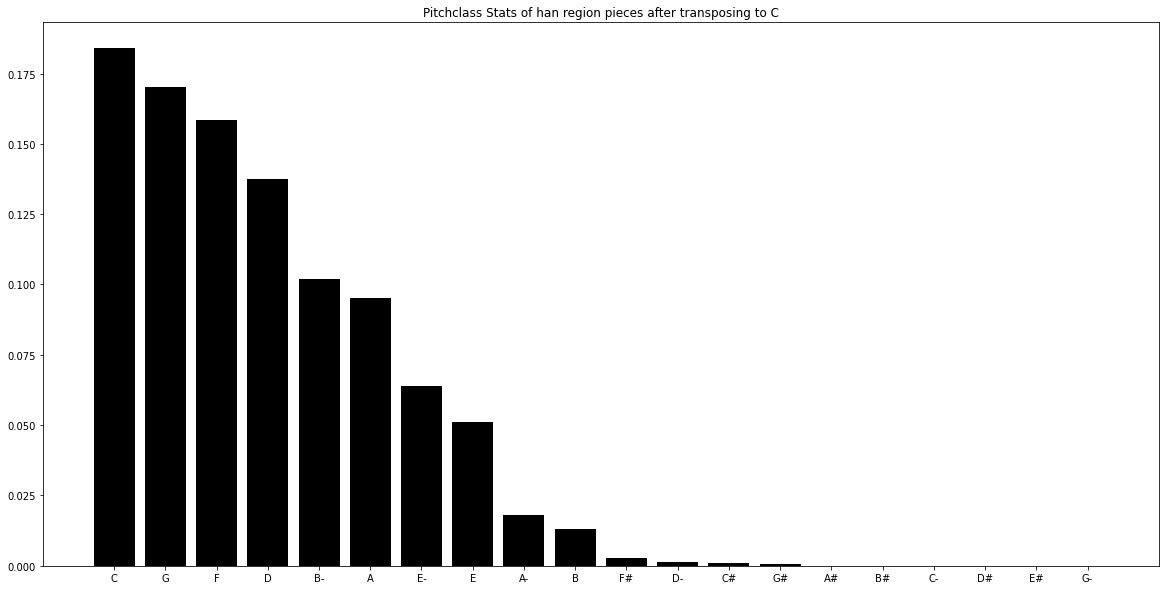

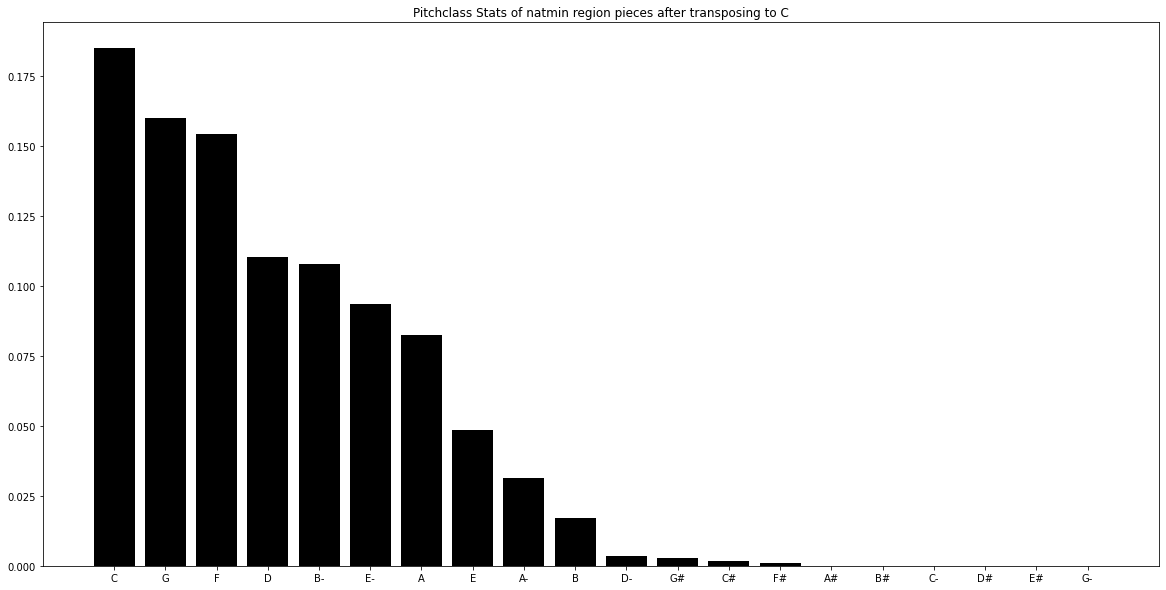

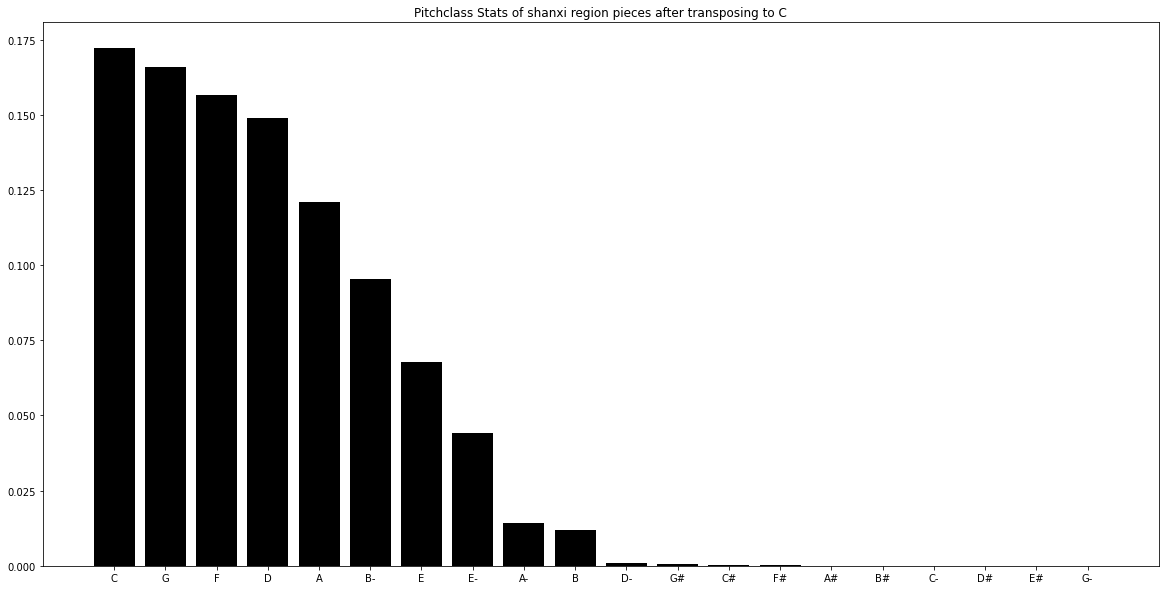

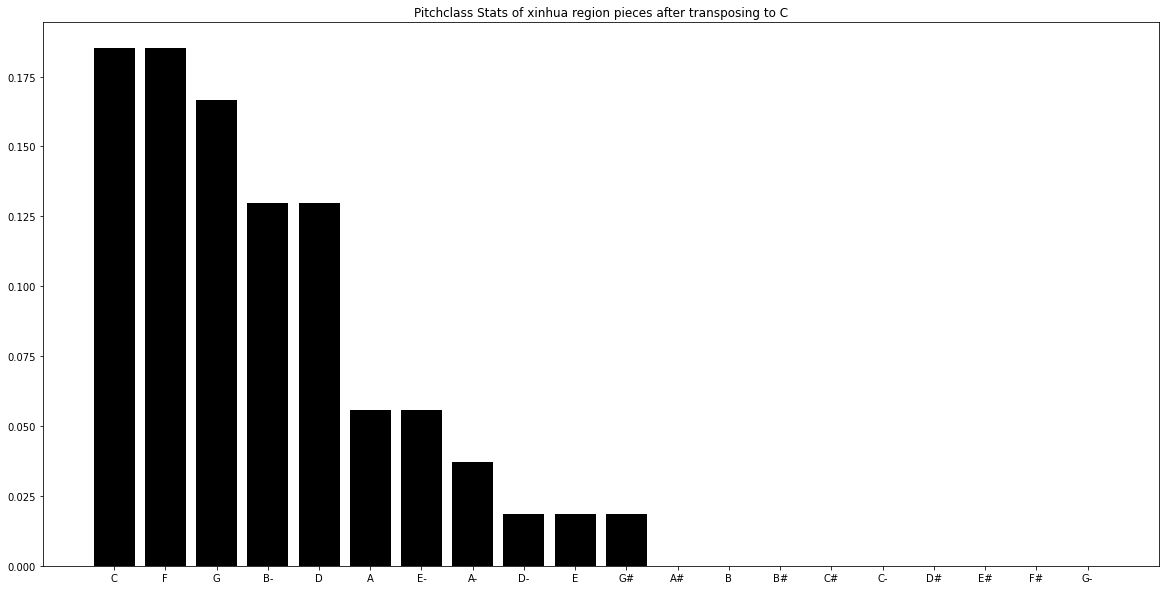

In [25]:
region_pitchclass_transposed_counts = {}
for gloc in region_pitchclass_transposed_stat:
    
    counter = Counter(region_pitchclass_transposed_stat[gloc])
    pitchclass_transposed_fractions = {i:counter[i] / len(region_pitchclass_transposed_stat[gloc]) for i in counter}
    pitchclass_transposed_fractions = {**pitchclasses_defcount, **pitchclass_transposed_fractions}
    region_pitchclass_transposed_counts[gloc] = sorted(pitchclass_transposed_fractions.items(), key=lambda pair: -pair[1])
    x, y = zip(*region_pitchclass_transposed_counts[gloc])
    plt.bar(x, y, color='black')
    plt.title("Pitchclass Stats of {} region pieces after transposing to C".format(gloc))
    plt.show()

Next, we look at the pitch transition in each region. For this, we create a network with pitch classes as nodes and the transitions between them as edges.

### Pitch Class Transition 

We create a dictionary to store the probability of transitions of the pitch classes in all pieces belonging to one region. The name of the region is the key of the mentioned dictionary and the value is a nested dictionary with keys as the starting pitch class and the values as dictionaries with key as the transitioned pitch class and value as the count of such occurrence.

Lastly, we normalize the transitions count of a pitch so that the sum is 1 and we can interpret it as a probability.

In [20]:
pitchclass_trasition = {}

for gloc in tqdm(music_data):
    gloc_pitchclass_transition = {}
    for score in music_data[gloc]["scores"]:
        for part in score.parts:
            for measure in part:
                if type(measure) is not stream.Measure:
                    continue
                prev = None
                for note_ in measure:
                    if type(note_) is not note.Note:
                        continue
                    if prev != None:
                        if prev not in gloc_pitchclass_transition:
                            gloc_pitchclass_transition[prev] = {}
                        if note_.name not in gloc_pitchclass_transition[prev]:
                            gloc_pitchclass_transition[prev][note_.name] = 1
                        else:
                            gloc_pitchclass_transition[prev][note_.name] += 1
                    prev = note_.name
    
    for pclass in  gloc_pitchclass_transition:
        tot_sum = sum( gloc_pitchclass_transition [pclass].values())
        for ptransclass in  gloc_pitchclass_transition[pclass]:
             gloc_pitchclass_transition[pclass][ptransclass] =  gloc_pitchclass_transition[pclass][ptransclass] / tot_sum
            
    pitchclass_trasition[gloc] = gloc_pitchclass_transition    

100%|██████████| 4/4 [00:01<00:00,  3.50it/s]


In [21]:
# function to sort a nested dictionary based on key
# credits: https://gist.github.com/gyli/f60f0374defc383aa098d44cfbd318eb

def sort_dict(item):
    return {k: sort_dict(v) if isinstance(v, dict) else v for k, v in sorted(item.items())}

Now using the pitch class transitions in each region we create a network with pitch class as the nodes and creating an edge in case there is a transition between the nodes. The graph will be directed meaning there exists an edge only in the direction where the pitch transition occurs.

We create a `plot_network` function to plot the created network that sizes the nodes of the network based on their degree and the thickness of edges based on the probability of transition meaning the darker the edge the probable the transition between those pitch classes.

Apart from plotting the graph, we also plot the transition probability as heatmaps to help in interpreting the probabilities. To create the heatmap, we first convert the transition probabilities from a dictionary to a data frame and use it to plot the heatmap. As the transitions are not bidirectional, the heatmap would not look symmetric.

In [22]:
plt.rcParams["figure.figsize"] = (20,10)
def plot_network(graph):
    weighted_degree = dict(graph.degree(weight='weight'))
    edges = graph.edges()
    weights = [5 * graph[u][v]['weight'] for u,v in edges]
    nx.draw_circular(graph, with_labels=True, alpha = 0.6, width=weights,
                  node_size=[v * 1000 for v in weighted_degree.values()])
    plt.axis("off")

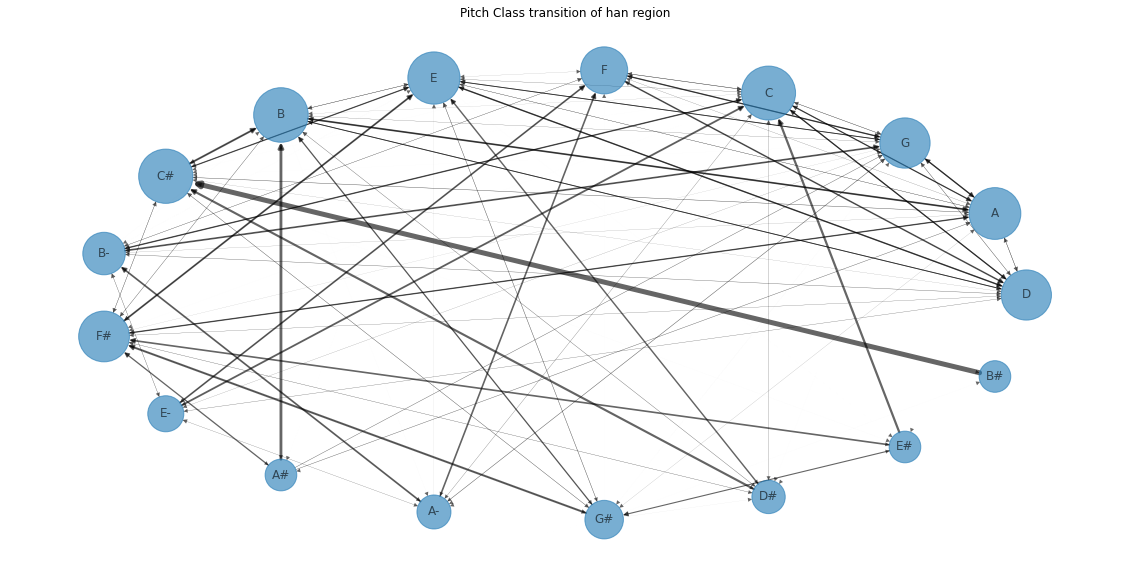

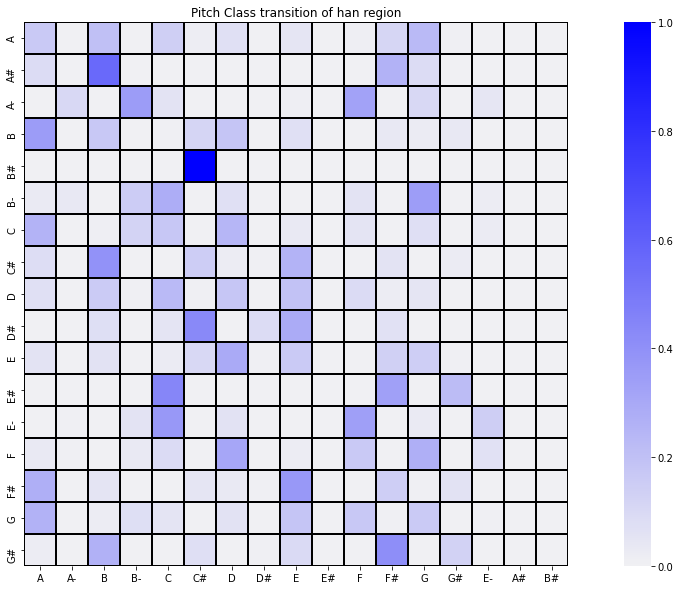

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


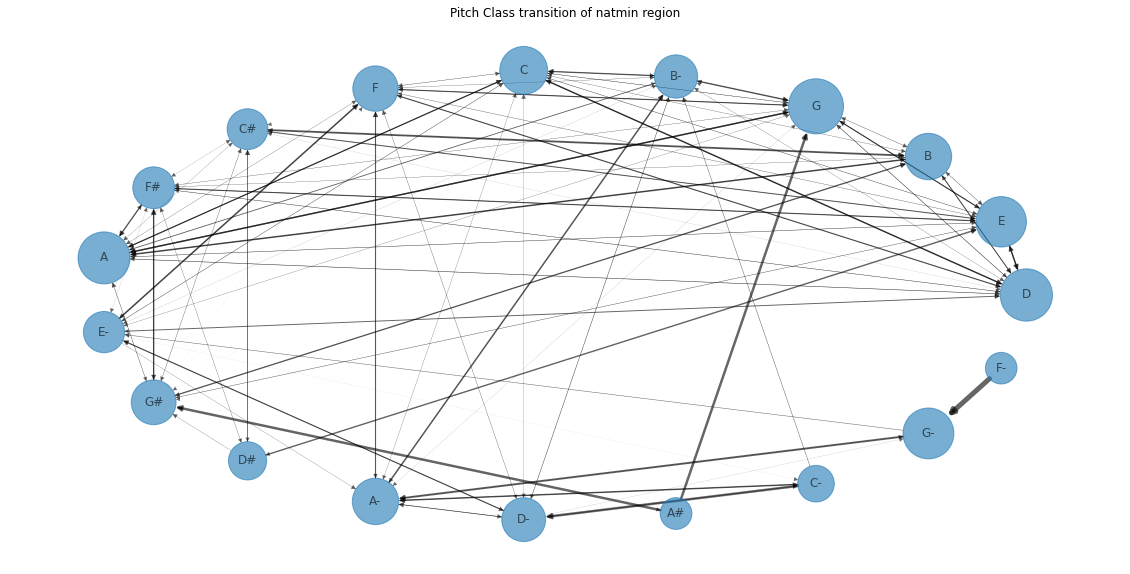

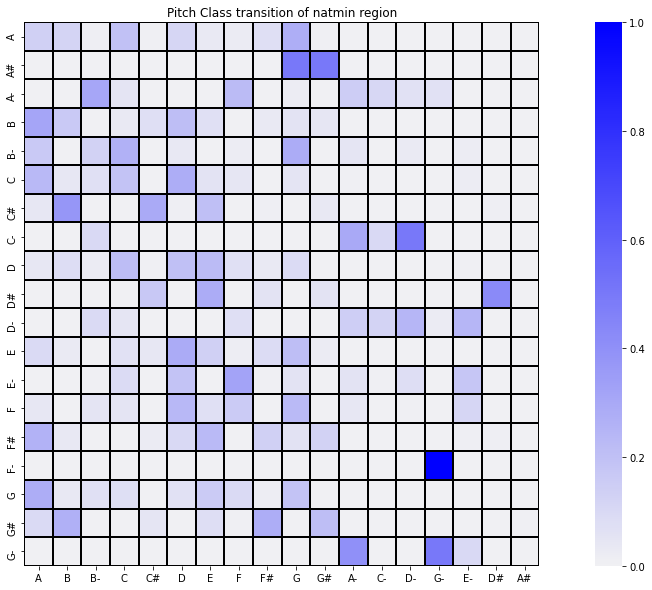

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


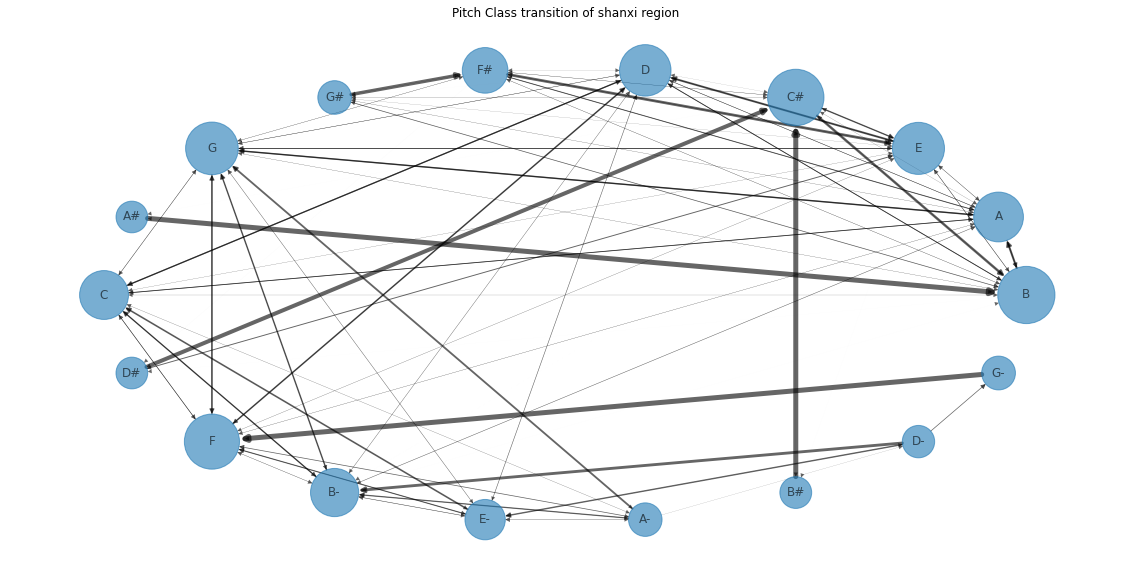

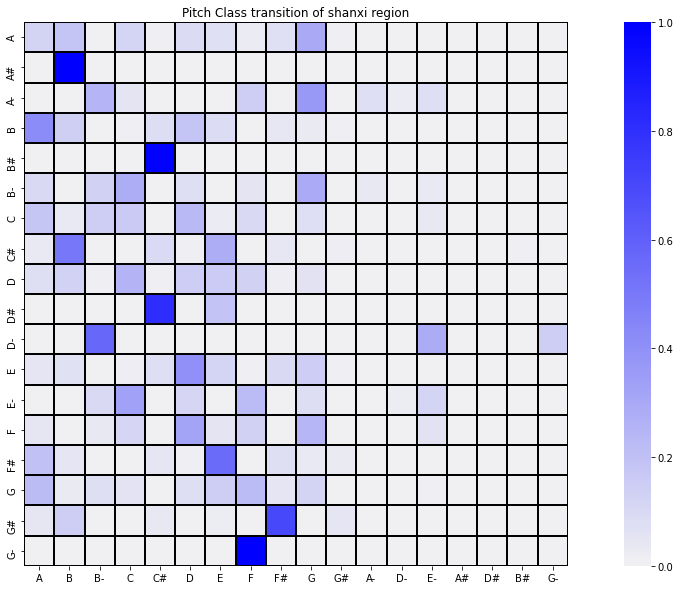

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


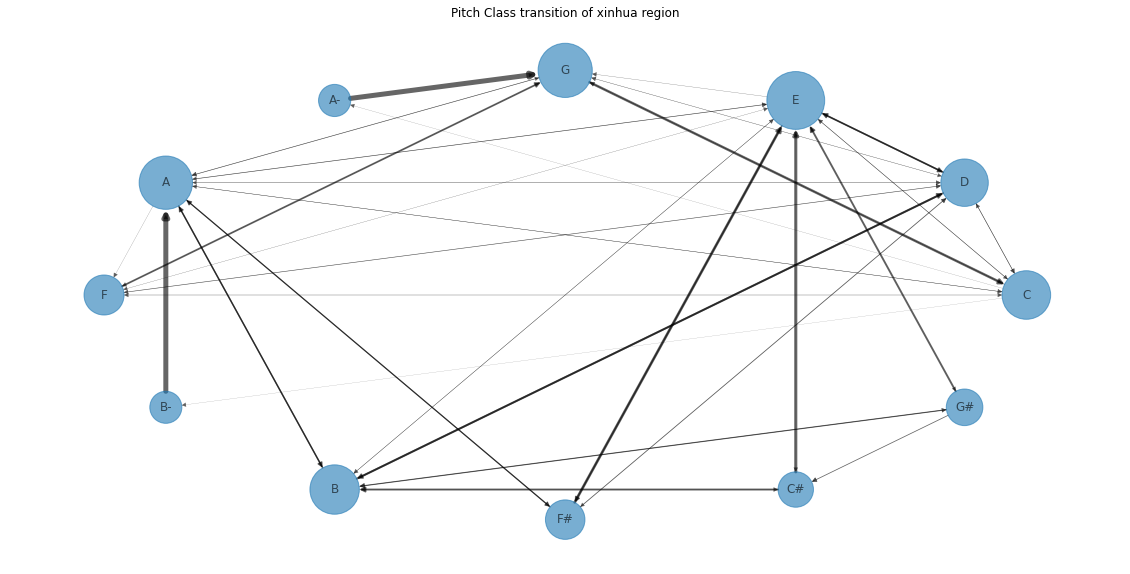

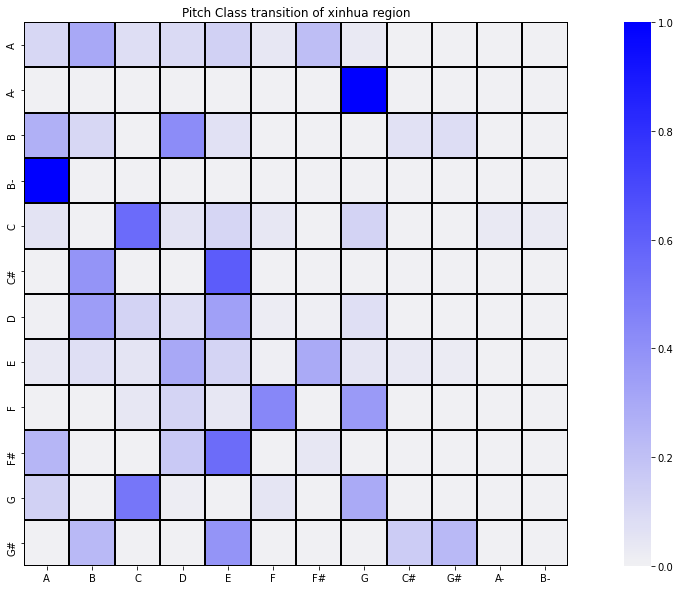

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [23]:
colormap = sns.color_palette("light:b", as_cmap=True)
for gloc in regions:
    gloc_graph = nx.DiGraph((k, v, {'weight': weight}) for k, vs in pitchclass_trasition[gloc].items() for v, weight in vs.items())
    plt.title("Pitch Class transition of {} region".format(gloc))
    plot_network(gloc_graph)
    plt.show()
    
    sorted_probs = sort_dict(pitchclass_trasition[gloc])
    gloc_matrix = pd.DataFrame.from_dict(sorted_probs).T.fillna(0)
    sns.heatmap(gloc_matrix, cmap= colormap, square=True, linecolor='black', linewidths=0.1, vmin=0)
    plt.title("Pitch Class transition of {} region".format(gloc))
    plt.show()
    
    print("--"*100)